In [1]:
%autocall 1
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from scienv import *

Automatic calling is: Smart


In [2]:
import utils as ut

In [3]:
from torchtext.data import Field, Example, TabularDataset
from torchtext.data import BucketIterator, Iterator
from torchtext.datasets import TranslationDataset
import torch as tc
from torchtext import data

In [5]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataset

In [6]:
PAD_TOKEN = "#"
MASK_TOKEN = "[]"
SRC = Field(sequential=True, tokenize=lambda s:s.strip().split(' '),
                     use_vocab=True, batch_first=True,
                     eos_token=None, init_token=None,
                     include_lengths=True, pad_token=PAD_TOKEN)
TRG = Field(sequential=True, tokenize=lambda s:s.strip().split(' '),
                     use_vocab=True, batch_first=True,
                     eos_token=None, init_token=None,
                     include_lengths=True, pad_token=PAD_TOKEN, is_target=True)

In [7]:
fields = [("src", SRC), ("trg", TRG)]

In [8]:
teDS = TranslationDataset(path='dataset/test/', exts=('in.txt','out.txt'), fields=fields)
trDS = TranslationDataset(path='dataset/train/', exts=('in.txt','out.txt'), fields=fields)

In [9]:
teDS_r = TranslationDataset(path='dataset/test/', exts=('out.txt','in.txt'), fields=fields)
trDS_r = TranslationDataset(path='dataset/train/', exts=('out.txt','in.txt'), fields=fields)

In [10]:
len(trDS),len(teDS)

(770491, 4000)

In [11]:
SRC.build_vocab(trDS, specials=[MASK_TOKEN], min_freq=2)
TRG.vocab = SRC.vocab
VOCAB = SRC.vocab
n_vocab = len(VOCAB)
n_vocab

6745

In [12]:
class Batch:
    def __init__(self, src=None, trg=None, 
                 src_pad_mask=None, trg_pad_mask=None,
                 trg_mask=None, trg_y=None):
        self.src=src
        self.trg=trg
        self.src_pad_mask=src_pad_mask
        self.trg_pad_mask=trg_pad_mask
        self.trg_mask=trg_mask
        self.trg_y=trg_y
    def __repr__(self):
        return 'Batch{\n  src: %s\n  trg: %s}'%(itos(self.src.cpu().numpy()),
                                  itos(self.trg.cpu().numpy()))
    
def format_couplets_str(first, second='', stoi={}, mask_token="[]"):
    first = list(first.replace(' ', '').replace(',', '，').replace('.', '。'))
    second = [s.replace(' ', mask_token) for s in second]
    l = (len(first)-len(second))
    assert l >= 0
    second = second + [mask_token] * l
    return [stoi.get(s, s) for s in first], [stoi.get(s, s) for s in second]

def str_to_batch(first, second, stoi, mask_token):
    src, trg = format_couplets_str(first, second, stoi, mask_token)
    src = tc.LongTensor(src).unsqueeze(0)
    trg = tc.LongTensor(trg).unsqueeze(0)
    src_pad_mask = tc.ones_like(src, dtype=bool)
    trg_pad_mask = tc.ones_like(trg, dtype=bool)
    trg_mask = trg != stoi[mask_token]
    return Batch(src, trg, src_pad_mask,trg_pad_mask,trg_mask)

def itos(i, itos=VOCAB.itos):
    return ut.apply(''.join, ut.apply(itos.__getitem__, i), 
                    at=lambda c:not ut.iscollection(c[0][0]))

In [13]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

In [14]:
def gen_trg_mask(trg, lens, r, pad):
    size = trg.size()
    mask = tc.rand(size) > r
    pad_mask = trg != pad
    ri = [np.random.randint(i) for i in lens] #至少mask1个
    mask[list(range(len(ri))),ri] = False    
    return mask, pad_mask

def gen_src_mask(src, pad):
    pad_mask = src != pad
    return pad_mask


In [15]:
def parse_pybatch(b, mask_ratio='rand'):
    mask_ratio = np.random.rand() if mask_ratio=='rand' else mask_ratio
    src = b.src[0]
    trg = b.trg[0]
    trg_mask, trg_pad_mask = gen_trg_mask(trg, b.trg[1], mask_ratio, VOCAB.stoi[PAD_TOKEN])
    src_pad_mask = gen_src_mask(src, VOCAB.stoi[PAD_TOKEN])
    trg_mask = trg_mask.to(DEVICE)
    trg_pad_mask = trg_pad_mask.to(DEVICE)
    src_pad_mask = src_pad_mask.to(DEVICE)
    trg_m = trg.masked_fill(~trg_mask, VOCAB.stoi[MASK_TOKEN])
    trg_m.masked_fill_(~trg_pad_mask, VOCAB.stoi[PAD_TOKEN])
    return Batch(src, trg_m, src_pad_mask,trg_pad_mask,trg_mask,trg)



In [16]:
str_to_batch('白日依山尽',' 河  流', mask_token=MASK_TOKEN, stoi=VOCAB.stoi)

Batch{
  src: ['白日依山尽']
  trg: ['[]河[][]流']}

In [17]:
IT = MyIterator(teDS, 5, sort_key=lambda x: len(x.src), shuffle=True, device=tc.device('cuda'))

for b in IT:
    r = parse_pybatch(b)
    print(r)
    print(itos(r.trg_y.cpu().numpy()))
    break

Batch{
  src: ['无尽枫红舒望眼', '痴我风姿应是月', '题到秋深诗句冷', '发情牛马难成对', '好烟孬烟都不好']
  trg: ['[]时柳[]展[]眉', '[]伊倩影胜如花', '[]回花落客魂寒', '得志[]狼[]简[]', '非语诽[][][][]']}
['几时柳绿展愁眉', '思伊倩影胜如花', '梦回花落客魂寒', '得志虎狼不简单', '非语诽语尽言非']


In [14]:
r.trg_mask.shape,r.trg_pad_mask.shape,r.src_pad_mask.shape

(torch.Size([5, 5]), torch.Size([5, 5]), torch.Size([5, 5]))

In [15]:
r.src.shape,r.trg.shape

(torch.Size([5, 5]), torch.Size([5, 5]))

In [365]:
r.src.dtype

torch.int64

In [16]:
r.src_pad_mask

tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True]], device='cuda:0')

# model

In [38]:
import torch
import torch as tc
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

In [80]:
from model import *

In [20]:
d_model = 512
em = Embeddings(d_model, n_vocab)

In [82]:
model = make_model(n_vocab, n_vocab)
model.to(DEVICE);

In [22]:
o = model(r.src, r.trg, r.src_pad_mask.unsqueeze(1), r.trg_pad_mask.unsqueeze(1))

In [23]:
o.shape

torch.Size([5, 7, 512])

In [24]:
criterion = LabelSmoothing(size=n_vocab, padding_idx=VOCAB.stoi[PAD_TOKEN], smoothing=0.0)

/mnt/cache/guoyongzhi/.conda/envs/gyz37/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [25]:
# opt = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
opt=None
loss_compute = SimpleLossCompute(model.generator, criterion, opt)

In [26]:
o = model(r.src, r.trg, r.src_pad_mask.unsqueeze(1), r.trg_pad_mask.unsqueeze(1))
loss_compute(o, r.trg_y, ignore_mask=r.trg_mask)

51.37674331665039

In [327]:
trainwriter = SummaryWriter('nomem/train')
testwriter = SummaryWriter('nomem/test')

In [328]:
trainwriter.add_graph(model, (r.src, r.trg, r.src_pad_mask.unsqueeze(1), r.trg_pad_mask.unsqueeze(1)))
trainwriter.flush()

/mnt/cache/guoyongzhi/couplets/model.py:218: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  pos = self.pe[:, :x.size(1)]
/mnt/cache/guoyongzhi/couplets/model.py:148: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  / math.sqrt(d_k)


# train

In [330]:
firsts = ['天与云与山与水，上下一白',
          '两个黄鹂鸣翠柳',
          '无边落木萧萧下', 
          '月落乌啼霜满天', 
          '提刀上马，江山如画', 
          '兰亭临帖，行书如行云流水',
          '荒烟漫草的年头，就连分手都很沉默',
          '一条大河波浪宽，风吹稻花香两岸',
          '我欲成仙，快乐齐天',
          '只有刚强的人，才有神圣的意志，凡是战斗的人，才能取得胜利',
          '？',
         ]

In [331]:
from model import *

In [332]:
def run_epoch(data_iter, model, loss_compute, mask_ratio='rand', step_call_back=lambda l:None):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    pred_tokens = 0
    total_pred_tokens = 0
    for i, batch in enumerate(data_iter):
        batch = parse_pybatch(batch,mask_ratio=mask_ratio)
        out = model.forward(batch.src,batch.trg, batch.src_pad_mask.unsqueeze(1), batch.trg_pad_mask.unsqueeze(1))
        ntokens = batch.src_pad_mask.sum().float()
        ntokens_pred = (batch.trg_pad_mask&(~batch.trg_mask)).sum().float()
        loss = loss_compute(out, batch.trg_y, ntokens, ignore_mask=batch.trg_mask)
        total_loss += loss
        total_tokens += ntokens.item()
        tokens += ntokens.item()
        pred_tokens += ntokens_pred.item()
        total_pred_tokens += ntokens_pred.item()
        step_call_back(loss/ntokens_pred)
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Step: %d Loss: %f Tokens per Sec: %f. mask ratio: %f" %
                    (i, loss / ntokens_pred, tokens / elapsed, pred_tokens/tokens))
            start = time.time()
            tokens = 0
            pred_tokens = 0
    return total_loss/total_pred_tokens

def train_log_cbk(loss):
    global step_counter
    step_counter += 1
    trainwriter.add_scalar('loss', loss, step_counter)

In [333]:
print(torch.cuda.device_count(), 'GPUs')
devices = list(range(torch.cuda.device_count()))

8 GPUs


In [334]:
IT_r = MyIterator(trDS_r, 4000, sort_key=lambda x: len(x.src), shuffle=True, device=torch.device('cuda'))
teIT_r = MyIterator(teDS_r, 240, sort_key=lambda x: len(x.src), shuffle=True, device=torch.device('cuda'))
IT = MyIterator(trDS, 4000, sort_key=lambda x: len(x.src), shuffle=True, device=torch.device('cuda'))
teIT = MyIterator(teDS, 240, sort_key=lambda x: len(x.src), shuffle=True, device=torch.device('cuda'))

model = make_model(n_vocab, n_vocab)
model.to(DEVICE)
criterion = LabelSmoothing(size=n_vocab, padding_idx=VOCAB.stoi[PAD_TOKEN], smoothing=0.7)
criterion = criterion.to(DEVICE)
criterion = nn.DataParallel(criterion, device_ids=devices)
opt = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
generator = nn.DataParallel(model.generator, device_ids=devices)
loss_compute = SimpleLossCompute(generator, criterion, opt)
model_par = nn.DataParallel(model, device_ids=devices)
step_counter = 0
para_num = sum(p.numel() for p in model_par.parameters())
trainable_para_num = sum(p.numel() for p in model_par.parameters() if p.requires_grad)
para_num, trainable_para_num

/mnt/cache/guoyongzhi/.conda/envs/gyz37/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


(52825311, 52825311)

In [335]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)

In [336]:
mr = 'rand'
# mr = 0.2
for epoch in range(20):
    model_par.train()
    run_epoch(IT, model_par, loss_compute, mask_ratio=mr, step_call_back=train_log_cbk)
    model_par.eval()
    loss = run_epoch(teIT, model_par, SimpleLossCompute(generator, criterion, None), mask_ratio=mr)
    testwriter.add_scalar('loss', loss, step_counter)
    testwriter.flush()
    trainwriter.flush()
    print('@', epoch, loss)

/mnt/cache/guoyongzhi/.conda/envs/gyz37/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step: 1 Loss: 1.917112 Tokens per Sec: 28459.874830. mask ratio: 0.370994
Step: 51 Loss: 1.748450 Tokens per Sec: 32371.496137. mask ratio: 0.576258
Step: 101 Loss: 1.799467 Tokens per Sec: 30848.980159. mask ratio: 0.609501
Step: 151 Loss: 1.754695 Tokens per Sec: 33107.219298. mask ratio: 0.507312
Step: 1 Loss: 1.872898 Tokens per Sec: 10353.018917. mask ratio: 0.257455
@ 0 1.7741159352484595
Step: 1 Loss: 1.743553 Tokens per Sec: 17459.377144. mask ratio: 0.334083
Step: 51 Loss: 1.797242 Tokens per Sec: 33893.259417. mask ratio: 0.539785
Step: 101 Loss: 1.771760 Tokens per Sec: 30394.028804. mask ratio: 0.528859
Step: 151 Loss: 1.727259 Tokens per Sec: 37029.062249. mask ratio: 0.595890
Step: 1 Loss: 1.738872 Tokens per Sec: 13104.386689. mask ratio: 0.749217
@ 1 1.746022359752104
Step: 1 Loss: 1.702263 Tokens per Sec: 19840.216587. mask ratio: 0.338175
Step: 51 Loss: 1.741686 Tokens per Sec: 30984.419383. mask ratio: 0.542386
Step: 101 Loss: 1.748284 Tokens per Sec: 34331.351806. m

In [337]:
from io import StringIO
sio = StringIO()
for first in firsts:
    print_match_all(first, beamsize=5, file=sio)
    print('\n', file=sio)
trainwriter.add_text(str(step_counter), sio.getvalue().replace('\n','\n\n').replace('\n\n\n\n','\n\n'), step_counter)
trainwriter.flush()

In [338]:
opt = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [339]:
mr = 'rand'
# mr = 0.2
for epoch in range(20):
    model_par.train()
    run_epoch(IT, model_par, loss_compute, mask_ratio=mr, step_call_back=train_log_cbk)
    model_par.eval()
    loss = run_epoch(teIT, model_par, SimpleLossCompute(generator, criterion, None), mask_ratio=mr)
    testwriter.add_scalar('loss', loss, step_counter)
    testwriter.flush()
    trainwriter.flush()
    print('@', epoch, loss)

Step: 1 Loss: 1.380375 Tokens per Sec: 19632.087375. mask ratio: 0.587318
Step: 51 Loss: 1.337274 Tokens per Sec: 31871.944031. mask ratio: 0.562394
Step: 101 Loss: 1.264298 Tokens per Sec: 32138.316232. mask ratio: 0.542487
Step: 151 Loss: 1.334353 Tokens per Sec: 33221.042192. mask ratio: 0.526440
Step: 1 Loss: 1.809319 Tokens per Sec: 9246.010353. mask ratio: 0.733333
@ 0 1.3579267184841002
Step: 1 Loss: 1.204264 Tokens per Sec: 6528.335306. mask ratio: 0.545571
Step: 51 Loss: 1.268560 Tokens per Sec: 35963.018655. mask ratio: 0.535755
Step: 101 Loss: 1.149702 Tokens per Sec: 32367.308957. mask ratio: 0.559831
Step: 151 Loss: 1.140520 Tokens per Sec: 33690.493131. mask ratio: 0.492375
Step: 1 Loss: 1.453105 Tokens per Sec: 8191.655570. mask ratio: 0.773264
@ 1 1.378246960909849
Step: 1 Loss: 1.304817 Tokens per Sec: 15618.425469. mask ratio: 0.598109
Step: 51 Loss: 1.257810 Tokens per Sec: 33323.477318. mask ratio: 0.537961
Step: 101 Loss: 1.498854 Tokens per Sec: 31902.294178. mask

In [340]:
from io import StringIO
sio = StringIO()
for first in firsts:
    print_match_all(first, beamsize=5, file=sio)
    print('\n', file=sio)
trainwriter.add_text(str(step_counter), sio.getvalue().replace('\n','\n\n').replace('\n\n\n\n','\n\n'), step_counter)
trainwriter.flush()

In [341]:
mr = 'rand'
# mr = 0.2
for epoch in range(20):
    model_par.train()
    run_epoch(IT, model_par, loss_compute, mask_ratio=mr, step_call_back=train_log_cbk)
    model_par.eval()
    loss = run_epoch(teIT, model_par, SimpleLossCompute(generator, criterion, None), mask_ratio=mr)
    testwriter.add_scalar('loss', loss, step_counter)
    testwriter.flush()
    trainwriter.flush()
    print('@', epoch, loss)

Step: 1 Loss: 1.282584 Tokens per Sec: 22140.243308. mask ratio: 0.491714
Step: 51 Loss: 1.227419 Tokens per Sec: 30843.124966. mask ratio: 0.596885
Step: 101 Loss: 1.339271 Tokens per Sec: 36835.752519. mask ratio: 0.599932
Step: 151 Loss: 1.025975 Tokens per Sec: 32734.072416. mask ratio: 0.559325
Step: 1 Loss: 1.235315 Tokens per Sec: 9275.237849. mask ratio: 0.616233
@ 0 1.1539560507919164
Step: 1 Loss: 1.180294 Tokens per Sec: 14047.080600. mask ratio: 0.665393
Step: 51 Loss: 1.253999 Tokens per Sec: 32310.493901. mask ratio: 0.568468
Step: 101 Loss: 1.206821 Tokens per Sec: 33830.257453. mask ratio: 0.609964
Step: 151 Loss: 1.117793 Tokens per Sec: 32905.980958. mask ratio: 0.499624
Step: 1 Loss: 0.915152 Tokens per Sec: 8221.574676. mask ratio: 0.346252
@ 1 1.1615135005018462
Step: 1 Loss: 1.311983 Tokens per Sec: 14079.563433. mask ratio: 0.536333
Step: 51 Loss: 1.088267 Tokens per Sec: 31736.411061. mask ratio: 0.574631
Step: 101 Loss: 1.055392 Tokens per Sec: 32429.407183. ma

In [342]:
from io import StringIO
sio = StringIO()
for first in firsts:
    print_match_all(first, beamsize=5, file=sio)
    print('\n', file=sio)
trainwriter.add_text(str(step_counter), sio.getvalue().replace('\n','\n\n').replace('\n\n\n\n','\n\n'), step_counter)
trainwriter.flush()

In [210]:
run_epoch(teIT_r, model_par, SimpleLossCompute(generator, criterion, None), mask_ratio=mr)

Step: 1 Loss: 4.593791 Tokens per Sec: 16180.098453. mask ratio: 0.813781


3.5329453869081977

In [221]:
model_par.eval()
run_epoch(teIT, model_par, SimpleLossCompute(generator, criterion, None), mask_ratio=mr)

Step: 1 Loss: 0.991790 Tokens per Sec: 12601.218376. mask ratio: 0.330149


1.1360541676955822

In [222]:
run_epoch(IT, model_par, SimpleLossCompute(generator, criterion, None), mask_ratio=mr)

Step: 1 Loss: 0.828012 Tokens per Sec: 30504.914129. mask ratio: 0.095151
Step: 51 Loss: 1.725160 Tokens per Sec: 45051.411805. mask ratio: 0.521330
Step: 101 Loss: 2.006808 Tokens per Sec: 46831.572388. mask ratio: 0.532648
Step: 151 Loss: 2.597104 Tokens per Sec: 48085.878949. mask ratio: 0.564236


2.6191998852524843

In [64]:
run_epoch(IT_r, model_par, SimpleLossCompute(generator, criterion, None), mask_ratio=mr)

Step: 1 Loss: 3.764093 Tokens per Sec: 17074.665737. mask ratio: 0.787457
Step: 51 Loss: 3.234247 Tokens per Sec: 47412.154484. mask ratio: 0.513269
Step: 101 Loss: 2.584729 Tokens per Sec: 42086.017133. mask ratio: 0.511079
Step: 151 Loss: 3.665455 Tokens per Sec: 45131.426026. mask ratio: 0.554868


3.102383682614523

In [43]:
from model import *

In [293]:
model.load_state_dict(torch.load('model_state_share03.pt'))

<All keys matched successfully>

# decode search

In [75]:
from decode_search import *

def match_couplet_onepass(first, second=''):
    '一次性输出，模型调用1次，效果不好'
    batch = str_to_batch(first, second, VOCAB.stoi, MASK_TOKEN)
    model.eval()
    out = model(batch.src.to(DEVICE), batch.trg.to(DEVICE), 
                batch.src_pad_mask.unsqueeze(1).to(DEVICE), batch.trg_pad_mask.unsqueeze(1).to(DEVICE))
    _, ind = torch.max(model.generator(out), dim = -1)
    return itos(ind.cpu().numpy())

def match_couplet_greedy(first, second=''):
    batch = str_to_batch(first, second, VOCAB.stoi, MASK_TOKEN)
    model.eval()
    trg_pred = decode_greedy(model, batch.src.to(DEVICE), batch.trg.to(DEVICE)
                             , mask_int=VOCAB.stoi[MASK_TOKEN], pad_int=VOCAB.stoi[PAD_TOKEN])
    return itos(trg_pred.cpu().numpy())

def match_couplet_beam_1D(first, second='', beamsize=5):
    batch = str_to_batch(first, second, VOCAB.stoi, MASK_TOKEN)
    model.eval()
    results = beam_decode_engine(model, batch.src.to(DEVICE), batch.trg.to(DEVICE), beamsize, decode_1D_step
                             , mask_int=VOCAB.stoi[MASK_TOKEN], pad_int=VOCAB.stoi[PAD_TOKEN])
    return itos([r.cpu().numpy() for r in results])

def match_couplet_beam_margin(first, second='', beamsize=5):
    batch = str_to_batch(first, second, VOCAB.stoi, MASK_TOKEN)
    model.eval()
    results = beam_decode_engine(model, batch.src.to(DEVICE), batch.trg.to(DEVICE), beamsize, decode_margin_step
                             , mask_int=VOCAB.stoi[MASK_TOKEN], pad_int=VOCAB.stoi[PAD_TOKEN])
    return itos([r.cpu().numpy() for r in results])

def match_couplet_beam_2D(first, second='', beamsize=5):
    '条件概率版本'
    batch = str_to_batch(first, second, VOCAB.stoi, MASK_TOKEN)
    model.eval()
    results = beam_decode_engine(model, batch.src.to(DEVICE), batch.trg.to(DEVICE), beamsize, decode_2D_step
                             , mask_int=VOCAB.stoi[MASK_TOKEN], pad_int=VOCAB.stoi[PAD_TOKEN])
    return itos([r.cpu().numpy() for r in results])

def match_couplet_beam_2D_2(first, second='', beamsize=5):
    '联合分布概率版本'
    batch = str_to_batch(first, second, VOCAB.stoi, MASK_TOKEN)
    model.eval()
    results = decode_beam_2D_2(model, batch.src.to(DEVICE), batch.trg.to(DEVICE), beamsize
                             , mask_int=VOCAB.stoi[MASK_TOKEN], pad_int=VOCAB.stoi[PAD_TOKEN])
    return itos([r.cpu().numpy() for r in results])

In [76]:
def decode_margin_step2(model, src, trg, mask, padmask, beamsize):
    '''
    各候选位置选最可能的字 + 最可能的位置选候选字，伪二维搜索
    padmask为True的是有效字，mask为True的是句中的给定字（非mask）
    '''
    model.eval()
#     print(padmask.unsqueeze(0).unsqueeze(1))
    assert src.size(0) == 1
    out = model(src, trg, padmask.unsqueeze(0).unsqueeze(1), padmask.unsqueeze(0).unsqueeze(1))
    g = model.generator(out)
    s, ind = torch.max(g, dim = -1)
    ignore = mask | (~padmask)
    s[0][ignore] = -1e9
    snp = s[0].detach().cpu().numpy() 
    pos = max_n_1D(np.array(snp), min(len(snp), beamsize//2))
    result = []
    keep_pos = pos[:(~ignore).sum().item()]
    for p in keep_pos:
        r = tc.clone(trg)
        r[0, p] = ind[0][p].item()
        result.append(r)
    logps = snp[keep_pos]
    max_pos = pos[0]
    g = g[0, max_pos].detach().cpu().numpy()
    ind = max_n_1D(g, min(len(g), beamsize-len(result)))
    
    for i in ind:
        r = tc.clone(trg)
        r[0, max_pos] = i
        result.append(r)
#     print(itos([r.cpu().numpy() for r in result]))
    return result

def beam_decode_engine2(model, src, trg, beamsize, decodestep, mask_int, pad_int):
    '候选的概率由logp_of_trg确定（联合分布）'
    padmask = (src!=pad_int).squeeze()
    result = [trg]
    while True:
        candidates = {}
        for trg in result:
            mask = (trg!=mask_int).squeeze()
            if mask.all(): 
                return result
            cands = decodestep(model, src, trg, mask, padmask, beamsize)
            for c in cands:
                candidates[tuple(c[0].tolist())] = c #去重
        cands = list(candidates.values())
        logps = [logp_of_trg(model, src, trgi, (trgi!=mask_int).squeeze(0), padmask) for trgi in cands]
        maxinds = max_n_1D(np.array(logps), min(len(logps), beamsize))
        result = [cands[i] for i in maxinds]
#         print(itos([r.cpu().numpy() for r in result]))
    return result

def match_couplet_beam_margin2(first, second='', beamsize=5):
    batch = str_to_batch(first, second, VOCAB.stoi, MASK_TOKEN)
    model.eval()
    results = beam_decode_engine2(model, batch.src.to(DEVICE), batch.trg.to(DEVICE), beamsize, decode_margin_step2
                             , mask_int=VOCAB.stoi[MASK_TOKEN], pad_int=VOCAB.stoi[PAD_TOKEN])
    return itos([r.cpu().numpy() for r in results])

In [636]:
out = model(src, trg, padmask.unsqueeze(0).unsqueeze(1), padmask.unsqueeze(0).unsqueeze(1))

In [738]:
model.generator(out).shape

torch.Size([1, 7, 6745])

In [77]:
def print_match_all(first, second='', beamsize=5, file=sys.stdout):
    print("上联:", first, file=file)
    print("onepass:", match_couplet_onepass(first, second), file=file)
    print("greedy :", match_couplet_greedy(first, second), file=file)
    print("beam_1D:\n", array(match_couplet_beam_1D(first, second, beamsize)), file=file)
    print("beam_2D:\n", array(match_couplet_beam_2D(first, second, beamsize)), file=file)
    print("beam_2D_2:\n", array(match_couplet_beam_2D_2(first, second, beamsize)), file=file)
    print("beam_margin:\n", array(match_couplet_beam_margin(first, second, beamsize)), file=file)
    print("beam_margin2:\n", array(match_couplet_beam_margin2(first, second, beamsize)), file=file)

In [140]:
firsts = ['天与云与山与水，上下一白',
          '两个黄鹂鸣翠柳',
          '无边落木萧萧下', 
          '月落乌啼霜满天', 
          '提刀上马，江山如画', 
          '兰亭临帖，行书如行云流水',
          '荒烟漫草的年头，就连分手都很沉默',
          '一条大河波浪宽，风吹稻花香两岸',
          '我欲成仙，快乐齐天',
          '只有刚强的人，才有神圣的意志，凡是战斗的人，才能取得胜利',
          '？',
         ]
for first in firsts:
    print_match_all(first, beamsize=5)
    print('\n')

上联: 天与云与山与水，上下一白
onepass: ['人同月同竹同风，古下同清']
greedy : ['人和诗和酒和诗，天地同春']
beam_1D:
 [['人同竹同竹同梅，上下两清']
 ['人同竹同竹同梅，上下双清']
 ['人和诗和画和诗，古今同辉']]


KeyboardInterrupt: 

In [148]:
for i, batch in enumerate(teIT):
    batch = parse_pybatch(batch,0.8)
    src = batch.src[:1]
    src_pad_mask = batch.src_pad_mask[:1]
    trg = batch.trg[:1]
    trg_y = batch.trg_y[:1]
    trg_mask = batch.trg_mask[:1]
    trg_pad_mask = batch.trg_pad_mask[:1]
#     out = decode(model, src, src_mask)
    print("src   :", itos(src.cpu().numpy()))
    print("true  :", itos(trg_y.cpu().numpy()))
    print("mask  :", [s.replace(MASK_TOKEN, "〇") for s in itos(trg.cpu().numpy())])
    print("greedy:", itos(decode_greedy(model, src, trg.clone(), 
                          mask_int=VOCAB.stoi[MASK_TOKEN], pad_int=VOCAB.stoi[PAD_TOKEN]).cpu().numpy()))
    print("beam 1D:\n", array(itos([r.cpu().numpy() for r in beam_decode_engine(model, src, trg.clone(), 5, decode_1D_step, 
                          mask_int=VOCAB.stoi[MASK_TOKEN], pad_int=VOCAB.stoi[PAD_TOKEN])])))
    print("beam 2D:\n", array(itos([r.cpu().numpy() for r in beam_decode_engine(model, src, trg.clone(), 5, decode_2D_step, 
                          mask_int=VOCAB.stoi[MASK_TOKEN], pad_int=VOCAB.stoi[PAD_TOKEN])])))
    print("beam 2D 2:\n", array(itos([r.cpu().numpy() for r in decode_beam_2D_2(model, src, trg.clone(), 5, 
                          mask_int=VOCAB.stoi[MASK_TOKEN], pad_int=VOCAB.stoi[PAD_TOKEN])])))
    print("beam margin:\n", array(itos([r.cpu().numpy() for r in beam_decode_engine(model, src, trg.clone(), 5, decode_margin_step, 
                          mask_int=VOCAB.stoi[MASK_TOKEN], pad_int=VOCAB.stoi[PAD_TOKEN])])))
    print('='*8)
    if i == 1:
        break

src   : ['莫让浮名耽岁月']
true  : ['且留正气满乾坤']
mask  : ['〇留正〇〇〇〇']
greedy: ['但留正气满乾坤']
beam 1D:
 [['但留正气度人生']
 ['但留正气满乾坤']]
beam 2D:
 [['但留正气度人生']
 ['但留正气写人生']
 ['但留正气满乾坤']
 ['但留正气壮乾坤']
 ['长留正气度人生']]
beam 2D 2:
 [['长留正气满乾坤']
 ['长留正气度人生']
 ['长留正气写人生']
 ['常留正气满乾坤']
 ['长留正道度人生']]
beam margin:
 [['但留正气度人生']
 ['但留正气满乾坤']
 ['长留正气满乾坤']
 ['但留正气写人生']
 ['但留正气壮乾坤']]
src   : ['风吹羊头夕阳醉']
true  : ['雨润丹河霞光美']
mask  : ['〇〇〇〇〇〇〇']
greedy: ['雨润田间谷穗香']
beam 1D:
 [['雨润田间谷穗香']
 ['雨润心田谷穗香']]
beam 2D:
 [['雨润田间谷穗香']
 ['雨润大地谷穗香']
 ['雨润田园谷穗香']
 ['雨润心田谷穗香']
 ['雨润田地谷穗香']]
beam 2D 2:
 [['花满人间春意浓']
 ['花满人间诗意浓']
 ['花开满园春意浓']
 ['花艳满园春意浓']
 ['花落人间春意浓']]
beam margin:
 [['雨润田间谷穗香']
 ['雨润田园谷穗香']
 ['雨润心田谷穗香']
 ['雨润田地谷穗香']
 ['雨润田田谷穗香']]


In [800]:
print_match_all('行书如行云流水', '')

上联: 行书如行云流水
onepass: ['明卷若明月阳风']
greedy : ['品茗若品月清风']
beam_1D:
 [['品茗似品竹啸风']
 ['品茗似品竹摇风']
 ['品茗若品竹摇风']
 ['明镜若明月清风']]
beam_2D:
 [['品茗似品竹摇风']
 ['品茗若品竹摇风']
 ['品茗似品竹啸风']
 ['品茗若品竹啸风']
 ['明月似明月清风']]
beam_2D_2:
 [['明镜似明月照人']
 ['明镜若明月照人']
 ['明镜自明月照人']
 ['明镜犹明月照人']
 ['展卷有展艳阳天']]
beam_margin:
 [['品茗似品竹摇风']
 ['品茗似品竹啸风']
 ['品茗若品竹摇风']
 ['品茗若品竹啸风']
 ['品德似品竹啸风']]


# visualization

In [343]:
sent = '天与云与山与水，上下一白'
model.eval()
pred = match_couplet_onepass(sent,'    花')
tgt_sent = pred[0]
pred

['人和月和花和月，春秋千红']

In [344]:
model.decoder.layers[0].self_attn.attn.shape

torch.Size([1, 8, 12, 12])

Encoder Layer 2


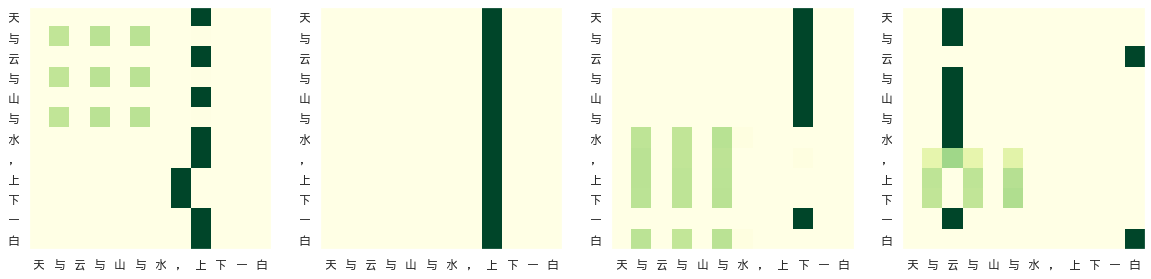

Encoder Layer 4


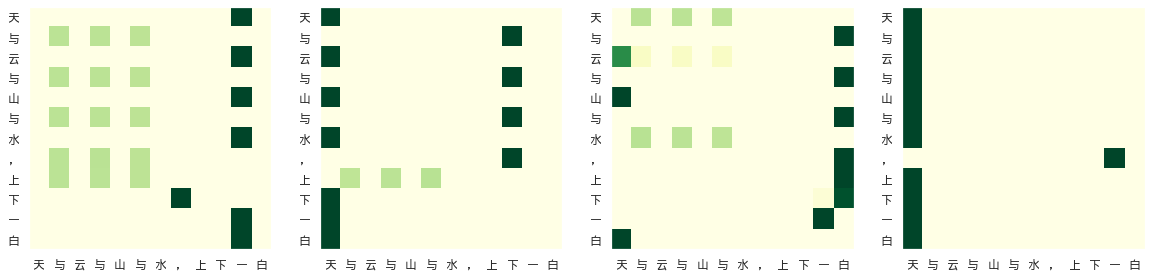

Encoder Layer 6


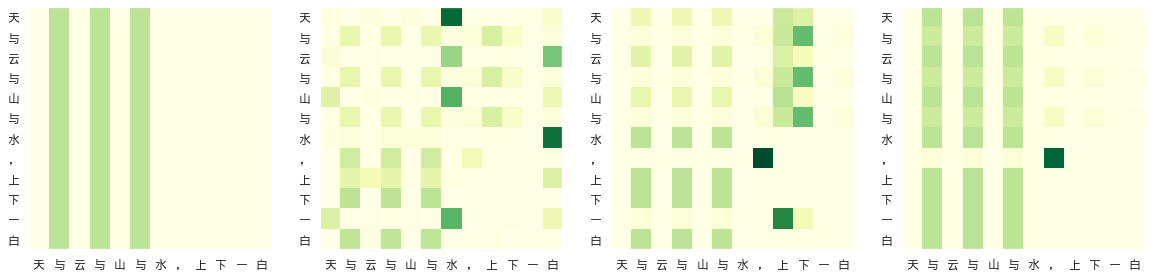

Decoder Self Layer 2


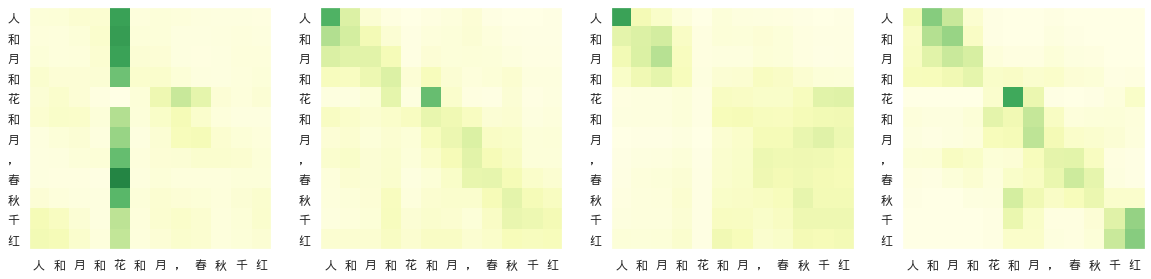

Decoder Src Layer 2


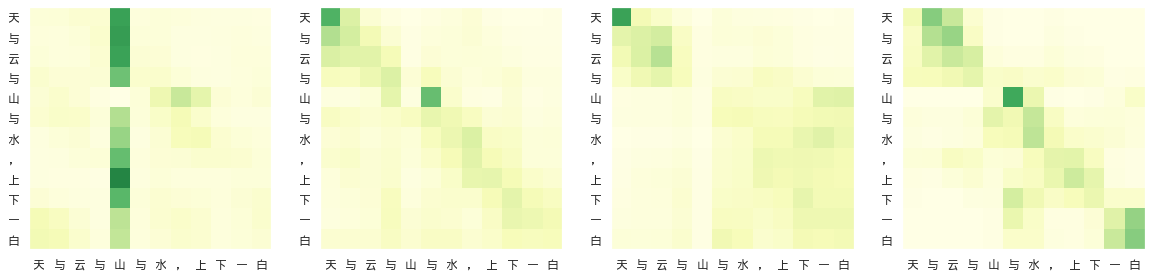

Decoder Self Layer 4


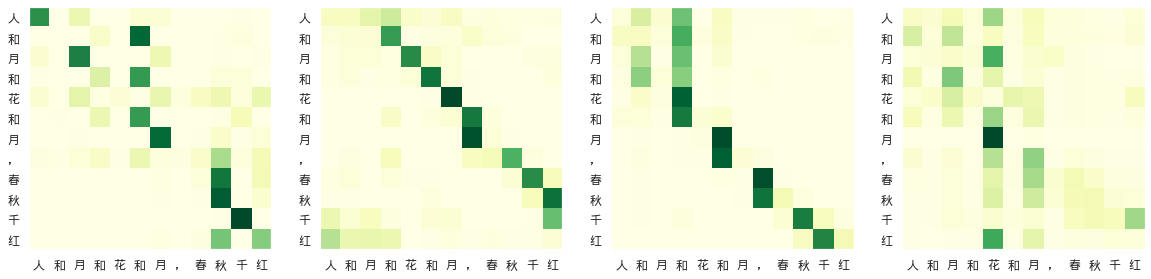

Decoder Src Layer 4


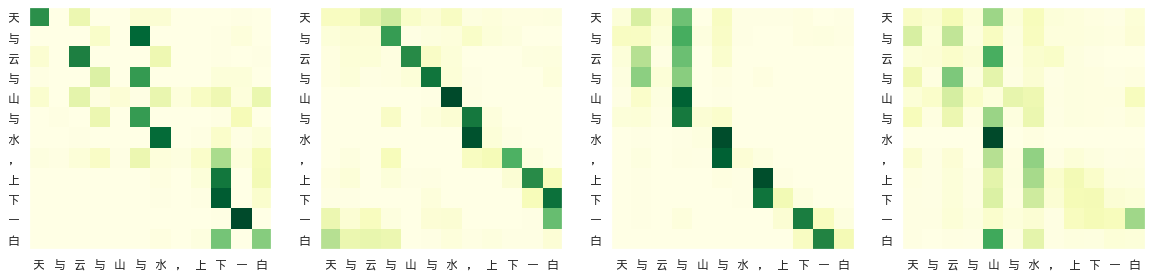

Decoder Self Layer 6


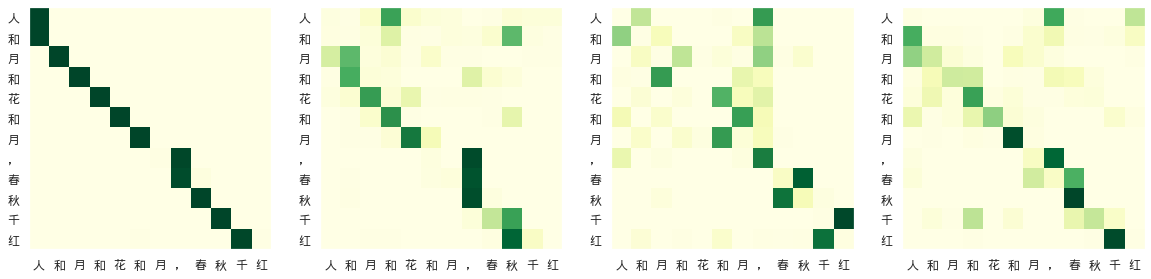

Decoder Src Layer 6


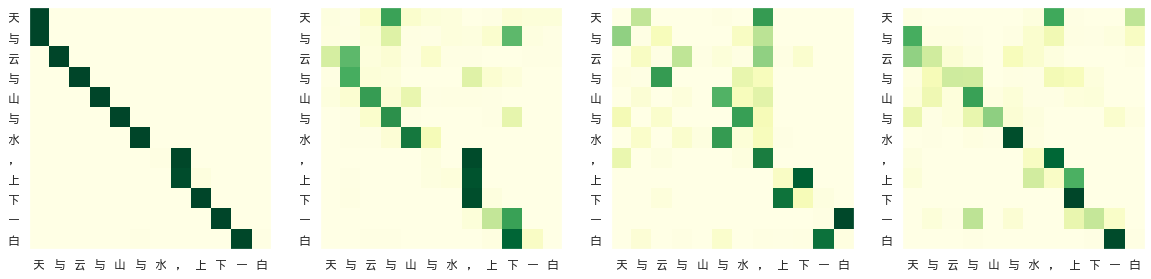

In [345]:
from matplotlib.font_manager import FontProperties
myfont=FontProperties(fname=r'wqy-microhei.ttc')
def draw(data, x, y, ax):
    ax.imshow(data, cmap='YlGn', vmin=0, vmax=1)
    ax.set_xticks(np.arange(len(x)))
    ax.set_yticks(np.arange(len(y)))
    ax.set_xticklabels(x, fontproperties=myfont)
    ax.set_yticklabels(y, fontproperties=myfont)
    ax.grid(False)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].cpu().data, 
            sent, sent, ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].cpu().data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent, ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].cpu().data[:len(sent), :len(sent)], 
            sent, sent, ax=axs[h])
    plt.show()
    
